# Classification, Pt 1

Classification, a method popular in machine learning, determines whether and how a model can distinguish between sets of text.

It works like this. Everyone with email relies on classification to separate spam from legitimate emails. Email providers train classification models to recognize the difference by giving them emails they have labeled “spam” and “not spam.” They then ask the model to learn the features that most reliably distinguish the two types, which could include a preponderance of all caps or phrases like “free money” or “get paid.” They test the model by giving it unlabeled emails and asking it to classify them. If the model can do it accurately a high percentage of the time, that’s a good spam filter.

We can take the underlying idea and apply it to many experiments.

## Today's experiment

We are going to use a corpus of obituaries from _The New York Times_ (Halloween / Dia de los Muertos appropriate!) in order to test whether our model can learn to distinguish between obituaries about men and women.

## Imports

As always, we begin with some imports.

In [1]:
import pandas as pd
import glob
from pathlib import Path
from pandas import DataFrame
from pandas import Series, DataFrame
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
from scipy.stats import pearsonr, norm

## Dataset

For this notebook, we'll be using a dataset of _New York Times_ obituaries. Let's import the gdown library so that we can load in the dataset and unzip it:

In [2]:
# For downloading large files from Google Drive
import gdown

# Download the zip file
gdown.download('https://drive.google.com/uc?export=download&id=1G0Aeg8dzZGPOCNFZ77U-s9CfEnR8efbB', quiet=False) 

Downloading...
From: https://drive.google.com/uc?export=download&id=1G0Aeg8dzZGPOCNFZ77U-s9CfEnR8efbB
To: /content/NYT-Obituaries.zip
100%|██████████| 2.53M/2.53M [00:00<00:00, 88.4MB/s]


'NYT-Obituaries.zip'

In [3]:
# unzip it 
!unzip NYT-Obituaries.zip

Archive:  NYT-Obituaries.zip
   creating: NYT-Obituaries/
  inflating: NYT-Obituaries/1945-Adolf-Hitler.txt  
  inflating: NYT-Obituaries/1915-F-W-Taylor.txt  
  inflating: NYT-Obituaries/1975-Chiang-Kai-shek.txt  
  inflating: NYT-Obituaries/1984-Ethel-Merman.txt  
  inflating: NYT-Obituaries/1953-Jim-Thorpe.txt  
  inflating: NYT-Obituaries/1964-Nella-Larsen.txt  
  inflating: NYT-Obituaries/1955-Margaret-Abbott.txt  
  inflating: NYT-Obituaries/1984-Lillian-Hellman.txt  
  inflating: NYT-Obituaries/1959-Cecil-De-Mille.txt  
  inflating: NYT-Obituaries/1928-Mabel-Craty.txt  
  inflating: NYT-Obituaries/1973-Eddie-Rickenbacker.txt  
  inflating: NYT-Obituaries/1989-Ferdinand-Marcos.txt  
  inflating: NYT-Obituaries/1991-Martha-Graham.txt  
  inflating: NYT-Obituaries/1997-Deng-Xiaoping.txt  
  inflating: NYT-Obituaries/1938-George-E-Hale.txt  
  inflating: NYT-Obituaries/1885-Ulysses-Grant.txt  
  inflating: NYT-Obituaries/1909-Sarah-Orne-Jewett.txt  
  inflating: NYT-Obituaries/1957-

In [4]:
# collect filepaths as files
directory = "./NYT-Obituaries/"
files = glob.glob(f"{directory}/*.txt")

len(files)

378

In [5]:
# and collect obit titles, which are also the final section of the filepaths
obit_titles = [Path(file).stem for file in files]
obit_titles

['1952-Eva-Peron',
 '1919-Anna-H-Shaw',
 '1978-Margaret-Mead',
 '1961-Primitive-Artist',
 '1915-B-T-Washington',
 '1999-Iris-Murdoch',
 '1955-Albert-Einstein',
 '1986-Jorge-Luis-Borges',
 '1960-Emily-Post',
 '1962-Eleanor-Roosevelt',
 '1989-Andrei-Sakharov',
 '1993-Cesar-Chavez',
 '1953-Marjorie-Rawlings',
 '1951-Fanny-Brice',
 '1959-John-Dulles',
 '1998-Maureen-O-Sullivan',
 '1960-Boris-Pasternak',
 '1984-Richard-Burton',
 '1979-Stan-Kenton',
 '1952-Charles-Spaulding',
 '1916-Jack-London',
 '1956-Babe-Zaharias',
 '1959-Cecil-De-Mille',
 '1995-Jonas-Salk',
 '1964-Sean-O-Casey',
 '1975-Chiang-Kai-shek',
 '1955-Cy-Young',
 '1910-Florence-Nightingale',
 '1885-Ulysses-Grant',
 '1964-Nella-Larsen',
 '1939-W-B-Yeats',
 '1941-Virginia-Woolf',
 '1969-Coleman-Hawkins',
 '1990-Rex-Harrison',
 '1954-Getulio-Vargas',
 '1990-Erte',
 '1983-Muddy-Waters',
 '1967-Gregory-Pincus',
 '1941-James-Joyce',
 '1994-Jan-Tinbergen',
 '1930-Conan-Doyle',
 '1935-Adolph-S-Ochs',
 '1964-Rachel-Carson',
 '1988-Louis

## Create document-term matrix

### Initiate CountVectorizer as vectorizer

Remember document-term matrices, aka doc-term matrices, aka dtms? We learned about them in our tf-idf notebooks. Our classifier uses a dtm as its input. We build it with scikit-learn's CountVectorizer, which we already imported up above. 

When we load our vectorizer, we include an argument to encode as utf-8 and we load our stopwords. In this case, we're using a custom stopwords list rather than the default sklearn one. You may end up using a custom stopwords list in your final projects. 

In addition, we can set the minimum number of times a word must appear in the corpus for it to be included in the dtm. In this case, I've set it at 20.

In [6]:
# another sklearn library to help load stopwords
from sklearn.feature_extraction import text

# Download the stopwords file
gdown.download('https://drive.google.com/uc?export=download&id=1BQ8zVSiG_WKpXNB81Y1P9yyi2L43UeJD', quiet=False) 

# open it 
text_file = open('./jockers_stopwords.txt')
jockers_words = text_file.read().split()
new_stopwords = text.ENGLISH_STOP_WORDS.union(jockers_words)

# create dtm
corpus_path = './NYT-Obituaries/'
vectorizer = CountVectorizer(input='filename', encoding='utf8', stop_words = new_stopwords, min_df=20, dtype='float64')

Downloading...
From: https://drive.google.com/uc?export=download&id=1BQ8zVSiG_WKpXNB81Y1P9yyi2L43UeJD
To: /content/jockers_stopwords.txt
100%|██████████| 44.5k/44.5k [00:00<00:00, 34.1MB/s]


### Make list of filepaths

If you recall, CountVectorizer builds a dtm from a list of filepaths. So we will provide that:

In [7]:
corpus = []
for title in obit_titles:
    filename = title + ".txt"
    corpus.append(corpus_path + filename)
dtm = vectorizer.fit_transform(corpus)

### Get feature names and set as column titles

The columns store word counts. We want to name the columns with the words stored in each, and to transform the dtm into a pandas dataframe, as follows:

In [8]:
vocab = vectorizer.get_feature_names_out()
matrix = dtm.toarray()
df = DataFrame(matrix, columns=vocab)
print('df shape is: ' + str(df.shape))

df shape is: (378, 2985)


Our dataframee has 378 rows, one for each document, or obituary, and 2985 columns, one for each word that's not in stopwords and appears at least 20 times in the corpus.

### Pandas interlude ###

I re-found [this](https://twitter.com/mmitchell_ai/status/1454931443386228751) on Twitter the other night, posted by Dr. Margaret Mitchell, the former co-lead of Google's EthicalAI group and now Big Deal at HuggingFace (the folx behind the transformer libraries we'll be using next week):

<img src="http://lklein.com/wp-content/uploads/2021/11/Screen-Shot-2021-11-01-at-10.14.24-AM.png" width=500px>

In any case, now it's time to import our metadata:

## Import metadata

In [9]:
gdown.download('https://drive.google.com/uc?export=download&id=1Pca0n-vWTy_FcF0oKWt9iHwxuBrDnxfd', quiet=False) 

meta = pd.read_csv("./NYT-Obituaries.csv", encoding = 'utf-8')
meta = meta.rename(columns={'title': 'obit_title'})
meta = meta[["obit_title", "gender", "date"]]
meta

Downloading...
From: https://drive.google.com/uc?export=download&id=1Pca0n-vWTy_FcF0oKWt9iHwxuBrDnxfd
To: /content/NYT-Obituaries.csv
100%|██████████| 5.64M/5.64M [00:00<00:00, 105MB/s]


,obit_title,gender,date
0,1945-Adolf-Hitler,0,1945.0
1,1915-F-W-Taylor,0,1915.0
2,1975-Chiang-Kai-shek,0,1975.0
3,1984-Ethel-Merman,1,1984.0
4,1953-Jim-Thorpe,0,1953.0
...,...,...,...
373,1987-Andres-Segovie,0,1987.0
374,1987-Rita-Hayworth,1,1987.0
375,1993-William-Golding,0,1993.0
376,1932-Florenz-Ziegfeld,1,1932.0


Our metadata is stored as a pandas dataframe with a row for each obituary and three columns: title, gender, and year.

Let's now concatinate the dtm to it so that everything is in one place. 

## Concatenate metadata and doc-term dataframe

We'll use the pandas `concat` methods, specifying that the data should be concatinated as additional columns (that's the `axis = 1` parameter. (The default would be `0` to concatinate as additional rows.) 

In [10]:
df_concat = pd.concat([meta, df], axis = 1)

In [11]:
df_concat.head()

,obit_title,gender,date,000,10,100,11,12,13,14,...,wrote,yale,year,years,yellow,yesterday,york,younger,youngest,youth
0,1945-Adolf-Hitler,0,1945.0,3.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,2.0,3.0,0.0,0.0,1.0,0.0,1.0,0.0
1,1915-F-W-Taylor,0,1915.0,6.0,0.0,1.0,0.0,2.0,0.0,1.0,...,1.0,0.0,5.0,6.0,1.0,1.0,3.0,0.0,0.0,1.0
2,1975-Chiang-Kai-shek,0,1975.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,14.0,0.0,1.0,1.0,0.0,0.0,0.0
3,1984-Ethel-Merman,1,1984.0,5.0,1.0,0.0,0.0,1.0,2.0,1.0,...,0.0,0.0,3.0,10.0,0.0,1.0,6.0,0.0,0.0,0.0
4,1953-Jim-Thorpe,0,1953.0,10.0,3.0,0.0,0.0,1.0,0.0,1.0,...,2.0,0.0,7.0,4.0,0.0,0.0,4.0,0.0,0.0,0.0


## Equalize numbers of men and women

We want our dataframe to have equal numbers of men and women. How many women are there? Women are counted as 1 and men as 0, so if we sum the gender column, we'll have the number of women:

In [12]:
meta['gender'].sum()

93

Then we separate men and women into two dataframes and take a random sample of 93 obituaries about men.

In [13]:
df_men = df_concat[df_concat['gender'] == 0]
df_women = df_concat[df_concat['gender'] == 1]
df_men = df_men.sample(n=93)

df_men

,obit_title,gender,date,000,10,100,11,12,13,14,...,wrote,yale,year,years,yellow,yesterday,york,younger,youngest,youth
185,1986-Bernard-Malamud,0,1986.0,7.0,1.0,1.0,2.0,2.0,1.0,3.0,...,9.0,0.0,7.0,12.0,0.0,0.0,0.0,0.0,1.0,0.0
160,1989-Claude-Pepper,0,1989.0,6.0,0.0,1.0,1.0,1.0,0.0,0.0,...,1.0,0.0,2.0,4.0,0.0,0.0,1.0,0.0,0.0,0.0
28,1981-Joe-Louis,0,1981.0,60.0,20.0,7.0,7.0,13.0,6.0,0.0,...,15.0,0.0,27.0,28.0,0.0,2.0,14.0,0.0,0.0,0.0
116,1930-Conan-Doyle,0,1927.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3.0,0.0,0.0,3.0,0.0,0.0,1.0,1.0,0.0,0.0
72,1998-Alan-B-Shepard-Jr,0,1998.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,...,5.0,0.0,2.0,7.0,0.0,1.0,6.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
256,1983-Jack-Dempsey,0,1983.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,3.0,1.0,1.0,10.0,0.0,1.0,7.0,1.0,0.0,0.0
52,1891-P-T-Barnum,0,1891.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,4.0,2.0,0.0,5.0,0.0,1.0,1.0,2.0,0.0,3.0
157,1988-John-Houseman,0,1988.0,0.0,0.0,0.0,2.0,1.0,0.0,0.0,...,0.0,0.0,1.0,3.0,0.0,1.0,1.0,0.0,0.0,0.0
261,1926-Harry-Houdini,0,1926.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,2.0,0.0,0.0,1.0,0.0,0.0,0.0


We then concatenate the sampled men dataframe with the women dataframe and reset the index.

In [14]:
df_final = pd.concat([df_men, df_women])
df_final = df_final.reset_index()
df_final = df_final.drop(columns="index")
df_final

,obit_title,gender,date,000,10,100,11,12,13,14,...,wrote,yale,year,years,yellow,yesterday,york,younger,youngest,youth
0,1986-Bernard-Malamud,0,1986.0,7.0,1.0,1.0,2.0,2.0,1.0,3.0,...,9.0,0.0,7.0,12.0,0.0,0.0,0.0,0.0,1.0,0.0
1,1989-Claude-Pepper,0,1989.0,6.0,0.0,1.0,1.0,1.0,0.0,0.0,...,1.0,0.0,2.0,4.0,0.0,0.0,1.0,0.0,0.0,0.0
2,1981-Joe-Louis,0,1981.0,60.0,20.0,7.0,7.0,13.0,6.0,0.0,...,15.0,0.0,27.0,28.0,0.0,2.0,14.0,0.0,0.0,0.0
3,1930-Conan-Doyle,0,1927.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3.0,0.0,0.0,3.0,0.0,0.0,1.0,1.0,0.0,0.0
4,1998-Alan-B-Shepard-Jr,0,1998.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,...,5.0,0.0,2.0,7.0,0.0,1.0,6.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
181,1910-Florence-Nightingale,1,1854.0,6.0,1.0,0.0,0.0,0.0,1.0,1.0,...,12.0,2.0,7.0,9.0,0.0,2.0,7.0,1.0,0.0,0.0
182,1986-The-Challenger,1,1986.0,0.0,2.0,1.0,0.0,1.0,0.0,0.0,...,3.0,0.0,6.0,11.0,0.0,0.0,0.0,2.0,1.0,1.0
183,1998-Galina-Ulanova,1,1998.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,4.0,0.0,0.0,2.0,1.0,0.0,0.0
184,1987-Rita-Hayworth,1,1987.0,0.0,0.0,0.0,3.0,0.0,0.0,2.0,...,4.0,0.0,9.0,5.0,0.0,0.0,12.0,0.0,0.0,0.0


We now have 186 rows: 93 men, 93 women.

### Match meta and data dataframes with subset of df_final

We'll continue to use meta and df, so we need to ensure they match our subsetted df_final

In [15]:
meta = df_final[["obit_title", "gender", "date"]]
meta

,obit_title,gender,date
0,1986-Bernard-Malamud,0,1986.0
1,1989-Claude-Pepper,0,1989.0
2,1981-Joe-Louis,0,1981.0
3,1930-Conan-Doyle,0,1927.0
4,1998-Alan-B-Shepard-Jr,0,1998.0
...,...,...,...
181,1910-Florence-Nightingale,1,1854.0
182,1986-The-Challenger,1,1986.0
183,1998-Galina-Ulanova,1,1998.0
184,1987-Rita-Hayworth,1,1987.0


In [16]:
df = df_final.loc[:,'000':]
df

,000,10,100,11,12,13,14,15,150,16,...,wrote,yale,year,years,yellow,yesterday,york,younger,youngest,youth
0,7.0,1.0,1.0,2.0,2.0,1.0,3.0,1.0,0.0,0.0,...,9.0,0.0,7.0,12.0,0.0,0.0,0.0,0.0,1.0,0.0
1,6.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,2.0,4.0,0.0,0.0,1.0,0.0,0.0,0.0
2,60.0,20.0,7.0,7.0,13.0,6.0,0.0,10.0,1.0,8.0,...,15.0,0.0,27.0,28.0,0.0,2.0,14.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,...,3.0,0.0,0.0,3.0,0.0,0.0,1.0,1.0,0.0,0.0
4,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,5.0,0.0,2.0,7.0,0.0,1.0,6.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
181,6.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,2.0,0.0,...,12.0,2.0,7.0,9.0,0.0,2.0,7.0,1.0,0.0,0.0
182,0.0,2.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,3.0,0.0,6.0,11.0,0.0,0.0,0.0,2.0,1.0,1.0
183,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,4.0,0.0,0.0,2.0,1.0,0.0,0.0
184,0.0,0.0,0.0,3.0,0.0,0.0,2.0,0.0,1.0,1.0,...,4.0,0.0,9.0,5.0,0.0,0.0,12.0,0.0,0.0,0.0


## Let's run our classifier!

Once we have a dataframe with metadata and vocab counts we're ready to run our classifier!

### We add columns for probabilities and predicted class to our metadata

As we run the model, we are going to store its output with our metadata. This will allow us to easily examine the model's output.

In [17]:
meta['PROBS'] = ''
meta['PREDICTED'] = ''

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


### Load model

We will use scikit-learn's `LogisticRegression` model. There are many other options for classifier models. Some are better for some tasks, other for others. LogisticRegression is standard for classifying literature. We set the penalty as L1 (Lasso / least absolute deviations) and the 'C' value as 1.0. 

If you decide to specialize in classification, you can explore further the implications of these regularization parameters. If you're curious now, [here is a nice intuitive primer](https://medium.com/analytics-vidhya/l1-vs-l2-regularization-which-is-better-d01068e6658c) on L1 vs the other main option, L2 (Ridge Regression). (In sk-learn, there is also an option in the middle, the Elastic-Net, which leads to an amount of sparsity between that of L1 and L2.)

As far as C, large values of C (like ours) give more freedom to the model. Conversely, smaller values of C (e.g. .1 or .01) constrain the model more.

In [18]:
model = LogisticRegression(penalty = 'l1', C = 1.0, solver='liblinear')

### Run the model!

We run the model in the following for-loop.

Classification models need classes: they need the texts grouped into different sets. Our metadata has built-in classes: gender. Men are stored as 0; women as 1. We could, if we wanted, create a new 0/1 class based on something else.

Each iteration trains on all the titles except one, then predicts which class the excluded title belongs to. We'll call this leave-one-out classification. It's helpful when you're working with a small dataset. There are other ways of dividing training and testing sets, which we won't explore today.

The first four indented lines simply track our progress by printing index, title, and class. The next four lines exclude a single title, and set the training data and the test data.

The final six lines fit the model, calculate the probabilities and predicted class of the test case, and add that information to our metadata dataframe.

In [19]:
for this_index in df_final.index.tolist():
    print(this_index) # keep track of where we are in the corpus
    title = meta.loc[meta.index[this_index], 'obit_title'] 
    CLASS = meta.loc[meta.index[this_index], 'gender']
    print(title, CLASS) 
    
    train_index_list = [index_ for index_ in df.index.tolist() if index_ != this_index] # exclude the title to be predicted
    X = df.loc[train_index_list] # the model trains on all the data except the excluded title row
    y = meta.loc[train_index_list, 'gender'] # the y row tells the model which class each title belongs to
    TEST_CASE = df.loc[[this_index]]

    model.fit(X,y) # fit the model
    prediction = model.predict_proba(TEST_CASE) # calculate probability of test case
    predicted = model.predict(TEST_CASE) # calculate predicted class of test case
    meta.at[this_index, 'PREDICTED'] = predicted # add predicted class to metadata
    meta.at[this_index, 'PROBS'] = str(prediction) # add probabilities to metadata
    print('Class is: ' + str(CLASS) + '\n' + 'Prediction is: ' + str(predicted) + ' ' + str(prediction) + '\n')

0
1986-Bernard-Malamud 0
Class is: 0
Prediction is: [1] [[0.46574015 0.53425985]]

1
1989-Claude-Pepper 0
Class is: 0
Prediction is: [0] [[0.74435739 0.25564261]]

2
1981-Joe-Louis 0
Class is: 0
Prediction is: [0] [[9.99768204e-01 2.31795884e-04]]

3
1930-Conan-Doyle 0
Class is: 0
Prediction is: [1] [[0.01378042 0.98621958]]

4
1998-Alan-B-Shepard-Jr 0
Class is: 0
Prediction is: [1] [[0.16943519 0.83056481]]

5
1992-William-Shawn 0
Class is: 0
Prediction is: [1] [[0.21113941 0.78886059]]

6
1894-R-L-Stevenson 0
Class is: 0
Prediction is: [0] [[0.50264444 0.49735556]]

7
1954-Liberty-H-Bailey 0
Class is: 0
Prediction is: [0] [[0.99366214 0.00633786]]

8
1945-FDR 0
Class is: 0
Prediction is: [0] [[0.71633104 0.28366896]]

9
1946-Lord-Keynes 0
Class is: 0
Prediction is: [0] [[0.57905963 0.42094037]]

10
1971-Hugo-Black 0
Class is: 0
Prediction is: [0] [[0.84875215 0.15124785]]

11
1922-Alexander-Graham-Bell 0
Class is: 0
Prediction is: [0] [[9.99842570e-01 1.57430265e-04]]

12
1954-Enrico

How cool is this! For each obituary, we see who it's about, that person's gender (0 or 1), and which gender the model thinks it's about, by which probabilities. 

## Results

Remember, we've stored our results in our metadata dataframe. Let's take a look!

In [20]:
meta

,obit_title,gender,date,PROBS,PREDICTED
0,1986-Bernard-Malamud,0,1986.0,[[0.46574015 0.53425985]],[1]
1,1989-Claude-Pepper,0,1989.0,[[0.74435739 0.25564261]],[0]
2,1981-Joe-Louis,0,1981.0,[[9.99768204e-01 2.31795884e-04]],[0]
3,1930-Conan-Doyle,0,1927.0,[[0.01378042 0.98621958]],[1]
4,1998-Alan-B-Shepard-Jr,0,1998.0,[[0.16943519 0.83056481]],[1]
...,...,...,...,...,...
181,1910-Florence-Nightingale,1,1854.0,[[0.55145868 0.44854132]],[0]
182,1986-The-Challenger,1,1986.0,[[0.75126188 0.24873812]],[0]
183,1998-Galina-Ulanova,1,1998.0,[[0.08470523 0.91529477]],[1]
184,1987-Rita-Hayworth,1,1987.0,[[0.0147597 0.9852403]],[1]


There's lots to look at here. We could explore probabilities: which obituaries is the model most sure about? Which are closest to 50-50? Which does it get most right and most wrong? Is there a pattern to misclassified obituaries?

For now, we just want to calculate its accuracy. Let's get rid of those brackets in the PREDICTED column.

In [21]:
meta = meta.replace([0], 0)
meta = meta.replace([1], 1)
meta

,obit_title,gender,date,PROBS,PREDICTED
0,1986-Bernard-Malamud,0,1986.0,[[0.46574015 0.53425985]],1
1,1989-Claude-Pepper,0,1989.0,[[0.74435739 0.25564261]],0
2,1981-Joe-Louis,0,1981.0,[[9.99768204e-01 2.31795884e-04]],0
3,1930-Conan-Doyle,0,1927.0,[[0.01378042 0.98621958]],1
4,1998-Alan-B-Shepard-Jr,0,1998.0,[[0.16943519 0.83056481]],1
...,...,...,...,...,...
181,1910-Florence-Nightingale,1,1854.0,[[0.55145868 0.44854132]],0
182,1986-The-Challenger,1,1986.0,[[0.75126188 0.24873812]],0
183,1998-Galina-Ulanova,1,1998.0,[[0.08470523 0.91529477]],1
184,1987-Rita-Hayworth,1,1987.0,[[0.0147597 0.9852403]],1


### Result column

Now we can add a 'RESULT' column that is the result of subtracting the predicted gender from the actual gender.

0 means the model was correct.
-1 means the model mistook a man for a woman.
1 means the model mistook a woman for a man.

In [22]:
sum_column = meta['gender'] - meta['PREDICTED']
meta['RESULT'] = sum_column
meta

,obit_title,gender,date,PROBS,PREDICTED,RESULT
0,1986-Bernard-Malamud,0,1986.0,[[0.46574015 0.53425985]],1,-1
1,1989-Claude-Pepper,0,1989.0,[[0.74435739 0.25564261]],0,0
2,1981-Joe-Louis,0,1981.0,[[9.99768204e-01 2.31795884e-04]],0,0
3,1930-Conan-Doyle,0,1927.0,[[0.01378042 0.98621958]],1,-1
4,1998-Alan-B-Shepard-Jr,0,1998.0,[[0.16943519 0.83056481]],1,-1
...,...,...,...,...,...,...
181,1910-Florence-Nightingale,1,1854.0,[[0.55145868 0.44854132]],0,1
182,1986-The-Challenger,1,1986.0,[[0.75126188 0.24873812]],0,1
183,1998-Galina-Ulanova,1,1998.0,[[0.08470523 0.91529477]],1,0
184,1987-Rita-Hayworth,1,1987.0,[[0.0147597 0.9852403]],1,0


Let's look at the accurate guesses.

In [23]:
# note that we're not wanting to rewrite the "meta" df here, just look at it
# so we won't reassign it
meta[meta['RESULT'] == 0]

,obit_title,gender,date,PROBS,PREDICTED,RESULT
1,1989-Claude-Pepper,0,1989.0,[[0.74435739 0.25564261]],0,0
2,1981-Joe-Louis,0,1981.0,[[9.99768204e-01 2.31795884e-04]],0,0
6,1894-R-L-Stevenson,0,1894.0,[[0.50264444 0.49735556]],0,0
7,1954-Liberty-H-Bailey,0,1954.0,[[0.99366214 0.00633786]],0,0
8,1945-FDR,0,1945.0,[[0.71633104 0.28366896]],0,0
...,...,...,...,...,...,...
170,1944-Ida-M-Tarbell,1,1944.0,[[0.07892379 0.92107621]],1,0
175,1956-Babe-Zaharias,1,1956.0,[[0.43235183 0.56764817]],1,0
176,1947-Willa-Cather,1,1947.0,[[0.00283001 0.99716999]],1,0
183,1998-Galina-Ulanova,1,1998.0,[[0.08470523 0.91529477]],1,0


## Accuracy

How many did the model get correct?

We can calculate its accuracy by dividing the correct number by the total.

In [25]:
# remember our filter approach from last week's pandas class
accuracy_filter =  meta['RESULT'] == 0

# apply the filter
accurate_results = meta[accuracy_filter]

# do our division 
# hint: you can just use the len() method to give you the length of a dataframe 


Hmm... At random, the model should guess correctly 50% of the time. 

## BONUS - Plotting a confusion matrix

In [26]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

[[44 49]
 [55 38]]


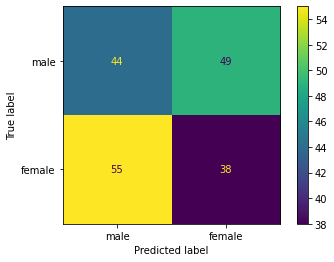

In [27]:
actual = meta['gender'].array   # remember that pandas columns are Series objects, so we need to convert them
predicted = meta['PREDICTED'].array

cm = confusion_matrix(actual, predicted) 

print(cm)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['male','female'])

disp.plot()
plt.show()

**What is this showing us?**

That's all for now!

In the next lesson, we'll explore _how_ the model made its calculations by learning which words matter.